In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/jgb-omr


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import re
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [10]:
# Old Version

'''
class RandomBoundaryDrop:
  def __init__(self, amount=3) -> None:
    self.amount = amount
  
  def __call__(self, img):
    rand_num = random.random()
    boundary_amount = random.randint(1, self.amount)
    if rand_num < 0.25:
      return img[:, :-boundary_amount] 
    elif rand_num < 0.5:
      return img[:, boundary_amount:]
    elif rand_num < 0.75:
      return img[:-boundary_amount, :]
    else:
      return img[boundary_amount:, :]

class Tokenizer:
  def __init__(self, entire_strs) -> None:
    self.entire_strs = entire_strs
    self.vocab = self.get_vocab()
    self.tok2idx = {tok: idx for idx, tok in enumerate(self.vocab)}

  def get_vocab(self):
    vocabs = {'\n', ','}
    for label in self.entire_strs:
      words = re.split(' |\n', label)
      words = [word.replace(',', '') for word in words]
      words = [word for word in words if word != '']
      vocabs.update(words)
    list_vocabs = sorted(list(vocabs))
    return ['<pad>', '<start>', '<end>'] + list_vocabs

  def __call__(self, label):
    label = label.replace('\n', ' \n ')
    label = label.replace(',', ' , ')
    words = label.split(' ')
    words = [word for word in words if word != '']
    words = ['<start>'] + words + ['<end>']
    return [self.tok2idx[word] for word in words]
  
  def __add__(self, other):
    return Tokenizer(self.entire_strs + other.entire_strs)

  def decode(self, labels):
    return ' '.join([self.vocab[idx] for idx in labels])

class Dataset:
  def __init__(self, csv_path, img_dir) -> None:
    self.df = pd.read_csv(csv_path)
    self.img_dir = Path(img_dir)
    self.transform = transforms.Compose([
    RandomBoundaryDrop(4),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: 1-x),
    # transforms.Resize((160, 140)),
    ])
    self.tokenizer = self._make_tokenizer()

  def _make_tokenizer(self):
    return Tokenizer(self.df['Annotations'].values.tolist())
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = cv2.imread( str(self.img_dir / row['Filename']))
    annotations = row['Annotations']
    img = self.transform(img)
    return img, self.tokenizer(annotations)
  



def pad_collate(raw_batch):
  # raw batch is a list of tuples (img, annotation)
  # img is torch tensor with shape (1, H, W)
  # pad to same width by adding 0s to the left and right
  # pad to same height by adding 0s to the top and bottom

  # find max width and height
  max_width = max([img.shape[2] for img, _ in raw_batch])
  max_height = max([img.shape[1] for img, _ in raw_batch])

  img_batch = torch.zeros((len(raw_batch), 1, max_height, max_width))
  for i, (img, _) in enumerate(raw_batch):
    h, w = img.shape[1], img.shape[2]
    left_pad = (max_width - w) // 2
    top_pad = (max_height - h) // 2
    img_batch[i, :, top_pad:top_pad+h, left_pad:left_pad+w] = img

  
  max_token_length = max([len(label) for _, label in raw_batch])
  label_batch = torch.zeros((len(raw_batch), max_token_length), dtype=torch.long)
  for i, (_, label) in enumerate(raw_batch):
    label_batch[i, :len(label)] = torch.tensor(label)
  

  return img_batch, label_batch[:, :-1], label_batch[:, 1:]
'''


class RandomBoundaryDrop:
  def __init__(self, amount=3) -> None:
    self.amount = amount
  
  def __call__(self, img):
    rand_num = random.random()
    boundary_amount = random.randint(1, self.amount)
    if rand_num < 0.25:
      return img[:, :-boundary_amount] 
    elif rand_num < 0.5:
      return img[:, boundary_amount:]
    elif rand_num < 0.75:
      return img[:-boundary_amount, :]
    else:
      return img[boundary_amount:, :]

class Tokenizer:
  def __init__(self, entire_strs) -> None:
    self.entire_strs = entire_strs
    self.vocab = self.get_vocab()
    self.tok2idx = {tok: idx for idx, tok in enumerate(self.vocab)}

  
  def tokenize_music_notation(self, notation):
    # Adjust the regex pattern to match:
    # - single spaces as separate tokens
    # - hyphens and colon-number pairs
    # - sequences of non-space, non-colon characters not starting with an underscore
    # - individual underscores followed by non-space, non-colon characters
    pattern = r'( +|[^_\s:]+|_+[^_\s:]+|:\d+|[-])'

    # Use re.findall to extract all matching tokens, including spaces
    tokens = re.findall(pattern, notation)
    return tokens

  def get_vocab(self):
    # vocabs = {'\n', ','}
    vocabs = set()
    for label in self.entire_strs:
      # words = re.split(' |\n', label)
      # words = [word.replace(',', '') for word in words]
      # words = [word for word in words if word != '']
      # vocabs.update(words)
      words = self.tokenize_music_notation(label)
      vocabs.update(words)
    list_vocabs = sorted(list(vocabs))
    return ['<pad>', '<start>', '<end>'] + list_vocabs

  def __call__(self, label):
    # label = label.replace('\n', ' \n ')
    # label = label.replace(',', ' , ')
    # words = label.split(' ')
    # words = [word for word in words if word != '']
    words = self.tokenize_music_notation(label)
    words = ['<start>'] + words + ['<end>']
    return [self.tok2idx[word] for word in words]
  
  def __add__(self, other):
    return Tokenizer(self.entire_strs + other.entire_strs)

  def decode(self, labels):
    return ''.join([self.vocab[idx] for idx in labels if self.vocab[idx] != '<pad>'])

class Dataset:
  def __init__(self, csv_path, img_dir) -> None:
    self.df = pd.read_csv(csv_path)
    self.img_dir = Path(img_dir)
    self.transform = transforms.Compose([
    RandomBoundaryDrop(4),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: 1-x),
    # transforms.Resize((160, 140)),
    ])
    self.tokenizer = self._make_tokenizer()

  def _make_tokenizer(self):
    return Tokenizer(self.df['label'].values.tolist())
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = cv2.imread( str(self.img_dir / row['filename']))
    annotations = row['label']
    img = self.transform(img)
    return img, self.tokenizer(annotations)
  



def pad_collate(raw_batch):
  # raw batch is a list of tuples (img, annotation)
  # img is torch tensor with shape (1, H, W)
  # pad to same width by adding 0s to the left and right
  # pad to same height by adding 0s to the top and bottom

  # find max width and height
  max_width = max([img.shape[2] for img, _ in raw_batch])
  max_height = max([img.shape[1] for img, _ in raw_batch])

  img_batch = torch.zeros((len(raw_batch), 1, max_height, max_width))
  for i, (img, _) in enumerate(raw_batch):
    h, w = img.shape[1], img.shape[2]
    left_pad = (max_width - w) // 2
    top_pad = (max_height - h) // 2
    img_batch[i, :, top_pad:top_pad+h, left_pad:left_pad+w] = img

  
  max_token_length = max([len(label) for _, label in raw_batch])
  label_batch = torch.zeros((len(raw_batch), max_token_length), dtype=torch.long)
  for i, (_, label) in enumerate(raw_batch):
    label_batch[i, :len(label)] = torch.tensor(label)
  
  return img_batch, label_batch[:, :-1], label_batch[:, 1:]

dataset = Dataset('labels_from_ls.csv', 'jeongganbo-png/unique-char-pngs/')
pre_dataset = Dataset('cv_label.csv', 'jeongganbo-png/splited-pngs/')

tokenizer = dataset.tokenizer + pre_dataset.tokenizer
pre_dataset.tokenizer = tokenizer
dataset.tokenizer = tokenizer


data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

batch = next(iter(data_loader)) 
batch
# dataset.tokenizer.vocab

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.8810, 0.8787, 0.8810,  ..., 0.8787, 0.8787, 0.0000],
           [0.8787

In [7]:
import koreanize_matplotlib

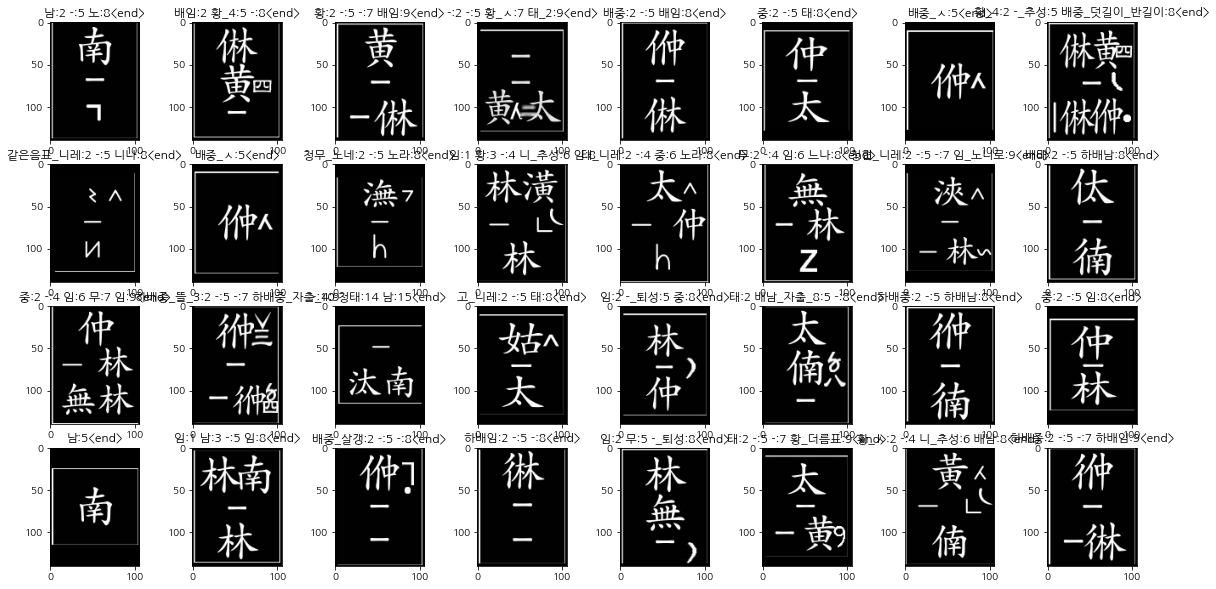

In [18]:
# data_loader = torch.utils.data.DataLoader(pre_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

batch = next(iter(data_loader))
imgs, labels, labels_shifted = batch

idx = 1
plt.figure(figsize=(20, 10))
for img, label, label_shifted in zip(imgs, labels, labels_shifted):
  plt.subplot(4, 8, idx)
  plt.imshow(img.squeeze().numpy(), cmap='gray')
  plt.title(tokenizer.decode(label[1:]))
  idx += 1

In [33]:
dataset.tokenizer.decode(label)

'<start>임_노니로:2 -:4 노:6 무_느니르:8<end>'

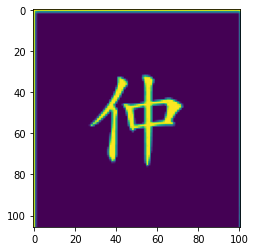

In [18]:
plt.imshow(img[0])

['청고', '_니레', ':10', '-', ':14', '청태', ':15']

In [15]:
dataset.df['label'].values.tolist()[5]

'무:2 -:5 황:8'

In [42]:
import shutil
import os

src_dir = "jeongganbo-png/splited-pngs/unique-char-pngs"
dst_dir = "jeongganbo-png/splited-pngs"

# Get the list of files in the source directory
file_list = os.listdir(src_dir)

# Move each file to the destination directory
for file_name in file_list:
  src_path = os.path.join(src_dir, file_name)
  dst_path = os.path.join(dst_dir, file_name)
  shutil.move(src_path, dst_path)


In [54]:
class CVDataset(Dataset):
  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img = cv2.imread( str(self.img_dir / row['filename']))
    annotations = row['label']
    annotations = annotations.split(':')[0]
    img = self.transform(img)
    return img, self.tokenizer(annotations)
  
  def _make_tokenizer(self):
    chars = self.df['label'].values.tolist()
    chars = [char.split(':')[0] for char in chars]
    return Tokenizer(chars)

dataset = Dataset('pairs.csv', 'jeongganbo-png/unique-char-pngs/')
cv_dataset = CVDataset('cv_label.csv', 'jeongganbo-png/splited-pngs/')
tokenizer = dataset.tokenizer + cv_dataset.tokenizer
cv_dataset.tokenizer = tokenizer
dataset.tokenizer = tokenizer
# cv_dataset.df 

cv_data_loader = torch.utils.data.DataLoader(cv_dataset, batch_size=256, shuffle=True, collate_fn=pad_collate)

In [56]:

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    # self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.GELU()

  def forward(self, x):
    x = self.conv(x)
    # x = self.bn(x)
    x = self.relu(x)
    return x


class ContextAttention(nn.Module):
  def __init__(self, size, num_head):
    super(ContextAttention, self).__init__()
    self.attention_net = nn.Linear(size, size)
    self.num_head = num_head

    if size % num_head != 0:
        raise ValueError("size must be dividable by num_head", size, num_head)
    self.head_size = int(size/num_head)
    self.context_vector = torch.nn.Parameter(torch.Tensor(num_head, self.head_size, 1))
    nn.init.uniform_(self.context_vector, a=-1, b=1)

  def get_attention(self, x):
    attention = self.attention_net(x)
    attention_tanh = torch.tanh(attention)
    attention_split = torch.stack(attention_tanh.split(split_size=self.head_size, dim=2), dim=0)
    similarity = torch.bmm(attention_split.view(self.num_head, -1, self.head_size), self.context_vector)
    similarity = similarity.view(self.num_head, x.shape[0], -1).permute(1,2,0)
    return similarity

  def forward(self, x):
    attention = self.attention_net(x)
    attention_tanh = torch.tanh(attention)
    if self.head_size != 1:
      attention_split = torch.stack(attention_tanh.split(split_size=self.head_size, dim=2), dim=0)
      similarity = torch.bmm(attention_split.view(self.num_head, -1, self.head_size), self.context_vector)
      similarity = similarity.view(self.num_head, x.shape[0], -1).permute(1,2,0)
      similarity[x.sum(-1)==0] = -1e10 # mask out zero padded_ones
      softmax_weight = torch.softmax(similarity, dim=1)

      x_split = torch.stack(x.split(split_size=self.head_size, dim=2), dim=2)
      weighted_x = x_split * softmax_weight.unsqueeze(-1).repeat(1,1,1, x_split.shape[-1])
      attention = weighted_x.view(x_split.shape[0], x_split.shape[1], x.shape[-1])
    else:
      softmax_weight = torch.softmax(attention, dim=1)
      attention = softmax_weight * x

    sum_attention = torch.sum(attention, dim=1)
    return sum_attention

class OMRModel(nn.Module):
  def __init__(self, hidden_size, vocab_size, num_gru_layers=2):
    super().__init__()

    self.layers = nn.Sequential(
          ConvBlock(1, hidden_size//4, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//4, hidden_size//4, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//4, hidden_size//2, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//2, hidden_size//2, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size//2, hidden_size, 3, 1, 1),
          nn.MaxPool2d(2, 2),
          ConvBlock(hidden_size, hidden_size, 3, 1, 1),
    )
    
    self.context_attention = ContextAttention(hidden_size, 4)
    self.cont2hidden = nn.Linear(hidden_size, hidden_size*num_gru_layers)
    self.cnn_gru = nn.GRU(hidden_size, hidden_size//2, 1, batch_first=True, dropout = 0.2, bidirectional=True)

    self.kv = nn.Linear(hidden_size, hidden_size*2)
    self.q = nn.Linear(hidden_size, hidden_size)
    self.num_head = 4

    self.emb = nn.Embedding(vocab_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, num_gru_layers, batch_first=True, dropout = 0.2)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_size, hidden_size * 4),
        nn.GELU(),
        nn.Linear(hidden_size * 4, hidden_size),
    )

    self.proj = nn.Linear(hidden_size*2, vocab_size)

  def run_img_cnn(self, x):
    x = self.layers(x)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(x.shape[0], -1, x.shape[-1])
    x = x.contiguous()
    x, _ = self.cnn_gru(x)

    context_vector = self.context_attention(x)
    context_vector = self.cont2hidden(context_vector.relu())
    context_vector = context_vector.reshape(x.shape[0], -1, context_vector.shape[-1]//2).permute(1,0,2)
    context_vector = context_vector.contiguous()

    return x, context_vector

  
  def forward(self, x, y):
    x, context_vector = self.run_img_cnn(x)
    y = self.emb(y)
    gru_out, _ = self.gru(y, context_vector)
    kv = self.kv(x)
    k, v = torch.split(kv, kv.shape[-1]//2, dim=-1)
    q = self.q(gru_out)
    attention_score = torch.bmm(q, k.permute(0,2,1))
    attention_score = torch.softmax(attention_score, dim=-1)

    attention = torch.bmm(attention_score, v)
    attention = self.mlp(attention)

    cat_out = torch.cat([gru_out, attention], dim=-1)
    logit = self.proj(cat_out)

    return logit

  @torch.inference_mode()  
  def inference(self, x):
    assert x.shape[0] == 1 # batch size must be 1

    x, last_hidden = self.run_img_cnn(x)
    kv = self.kv(x)
    k, v = torch.split(kv, kv.shape[-1]//2, dim=-1)

    y = torch.ones((1, 1), dtype=torch.long).to(x.device)
    outputs = []
    for _ in range(100):
      y = self.emb(y)
      gru_out, last_hidden = self.gru(y, last_hidden)
      q = self.q(gru_out)
      attention_score = torch.bmm(q, k.permute(0,2,1))
      attention_score = torch.softmax(attention_score, dim=-1)

      attention = torch.bmm(attention_score, v)
      attention = self.mlp(attention)

      cat_out = torch.cat([gru_out, attention], dim=-1)
      logit = self.proj(cat_out)
      y = torch.argmax(logit, dim=-1)
      if y == 2:
        break
      outputs.append(y.item())
    return outputs


model = OMRModel(128, vocab_size=len(tokenizer.vocab))
batch = next(iter(data_loader))
img, label, shifted_label = batch
out = model(img, label)
out.shape

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([32, 13, 117])

In [59]:
class Trainer:
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device, model_name='nmt_model'):
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    
    self.model.to(device)
    
    self.grad_clip = 1.0
    self.best_valid_accuracy = 0
    self.device = device
    
    self.training_loss = []
    self.validation_loss = []
    self.validation_acc = []
    self.model_name = model_name

  def save_model(self, path):
    torch.save({'model':self.model.state_dict(), 'optim':self.optimizer.state_dict()}, path)
    
  def train_by_num_epoch(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        loss_value = self._train_by_single_batch(batch)
        self.training_loss.append(loss_value)
      self.model.eval()
      validation_loss, validation_acc = self.validate()
      self.validation_loss.append(validation_loss)
      self.validation_acc.append(validation_acc)
      
      if validation_acc > self.best_valid_accuracy:
        print(f"Saving the model with best validation accuracy: Epoch {epoch+1}, Acc: {validation_acc:.4f} ")
        self.save_model(f'{self.model_name}_best.pt')
      else:
        self.save_model(f'{self.model_name}_last.pt')
      self.best_valid_accuracy = max(validation_acc, self.best_valid_accuracy)

      
  def _train_by_single_batch(self, batch):
    '''
    This method updates self.model's parameter with a given batch
    
    batch (tuple): (batch_of_input_text, batch_of_label)
    
    You have to use variables below:
    
    self.model (Translator/torch.nn.Module): A neural network model
    self.optimizer (torch.optim.adam.Adam): Adam optimizer that optimizes model's parameter
    self.loss_fn (function): function for calculating BCE loss for a given prediction and target
    self.device (str): 'cuda' or 'cpu'

    output: loss (float): Mean binary cross entropy value for every sample in the training batch
    The model's parameters, optimizer's steps has to be updated inside this method
    '''
    
    src, tgt_i, tgt_o = batch
    pred = self.model(src.to(self.device), tgt_i.to(self.device))
    loss = self.loss_fn(pred, tgt_o)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
    self.optimizer.step()
    self.optimizer.zero_grad()
    
    return loss.item()

    
  def validate(self, external_loader=None):
    '''
    This method calculates accuracy and loss for given data loader.
    It can be used for validation step, or to get test set result
    
    input:
      data_loader: If there is no data_loader given, use self.valid_loader as default.
      
    output: 
      validation_loss (float): Mean Binary Cross Entropy value for every sample in validation set
      validation_accuracy (float): Mean Accuracy value for every sample in validation set
    '''
    
    ### Don't change this part
    if external_loader and isinstance(external_loader, DataLoader):
      loader = external_loader
      print('An arbitrary loader is used instead of Validation loader')
    else:
      loader = self.valid_loader
      
    self.model.eval()
    
    '''
    Write your code from here, using loader, self.model, self.loss_fn.
    '''
    validation_loss = 0
    validation_acc = 0
    num_total_tokens = 0
    with torch.no_grad():
      for batch in tqdm(loader, leave=False):
        
        src, tgt_i, tgt_o = batch
        pred = self.model(src.to(self.device), tgt_i.to(self.device))
        loss = self.loss_fn(pred, tgt_o)
        num_tokens = (tgt_o != 0).sum().item()
        validation_loss += loss.item() * num_tokens
        num_total_tokens += num_tokens
        
        acc = torch.argmax(pred, dim=-1) == tgt_o.to(self.device)
        acc = acc[tgt_o != 0].sum()
        validation_acc += acc.item()
        
    return validation_loss / num_total_tokens, validation_acc / num_total_tokens

def get_nll_loss(predicted_prob_distribution, indices_of_correct_token, eps=1e-10, ignore_index=0):
  '''
  for PackedSequence, the input is 2D tensor
  
  predicted_prob_distribution has a shape of [num_entire_tokens_in_the_batch x vocab_size]
  indices_of_correct_token has a shape of [num_entire_tokens_in_the_batch]
  '''

  if predicted_prob_distribution.ndim == 3:
    predicted_prob_distribution = predicted_prob_distribution.reshape(-1, predicted_prob_distribution.shape[-1])
    indices_of_correct_token = indices_of_correct_token.reshape(-1)


  prob_of_correct_next_word = torch.log_softmax(predicted_prob_distribution, dim=-1)[torch.arange(len(predicted_prob_distribution)), indices_of_correct_token]
  filtered_prob = prob_of_correct_next_word[indices_of_correct_token != ignore_index]
  loss = -filtered_prob
  return loss.mean()

  
model = OMRModel(128, vocab_size=len(dataset.tokenizer.vocab))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, 
                                                               [int(len(dataset)*0.8), 
                                                                int(len(dataset)*0.1), 
                                                                len(dataset) - int(len(dataset)*0.8)  - int(len(dataset)*0.1)] )

pre_train_loader = DataLoader(cv_dataset, batch_size=256, shuffle=True, collate_fn=pad_collate)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=pad_collate)

trainer = Trainer(model, torch.optim.Adam(model.parameters(), lr=1e-3), get_nll_loss, train_loader, valid_loader, 'cuda')

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [60]:
pre_train_loader = DataLoader(cv_dataset, batch_size=256, shuffle=True, collate_fn=pad_collate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optimizer, lr=1e-3), get_nll_loss, pre_train_loader, valid_loader, 'cuda')
trainer.train_by_num_epoch(5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 1, Acc: 0.1501 


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 2, Acc: 0.1715 


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 4, Acc: 0.1746 


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 5, Acc: 0.1776 


In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, optimizer, get_nll_loss, train_loader, valid_loader, 'cuda')
trainer.train_by_num_epoch(100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 1, Acc: 0.2956 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 2, Acc: 0.4900 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 3, Acc: 0.5498 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 4, Acc: 0.5911 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 5, Acc: 0.6263 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 6, Acc: 0.6386 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 7, Acc: 0.6830 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 8, Acc: 0.6876 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 9, Acc: 0.6922 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 11, Acc: 0.6998 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 12, Acc: 0.7044 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 13, Acc: 0.7305 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 14, Acc: 0.7443 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 16, Acc: 0.7642 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 18, Acc: 0.7902 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 21, Acc: 0.7933 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 22, Acc: 0.8040 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 24, Acc: 0.8147 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 25, Acc: 0.8193 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 28, Acc: 0.8315 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 29, Acc: 0.8392 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 31, Acc: 0.8560 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 46, Acc: 0.8637 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 61, Acc: 0.8668 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 66, Acc: 0.8683 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 71, Acc: 0.8698 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 75, Acc: 0.8760 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation accuracy: Epoch 77, Acc: 0.8806 


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
trainer.train_by_num_epoch(30)

In [66]:


model = OMRModel(128, vocab_size=len(dataset.tokenizer.vocab))
model.load_state_dict(torch.load('nmt_model_best.pt')['model'])
tokenizer = dataset.tokenizer


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


'임 ^ \n - , 노 \n 중 )'

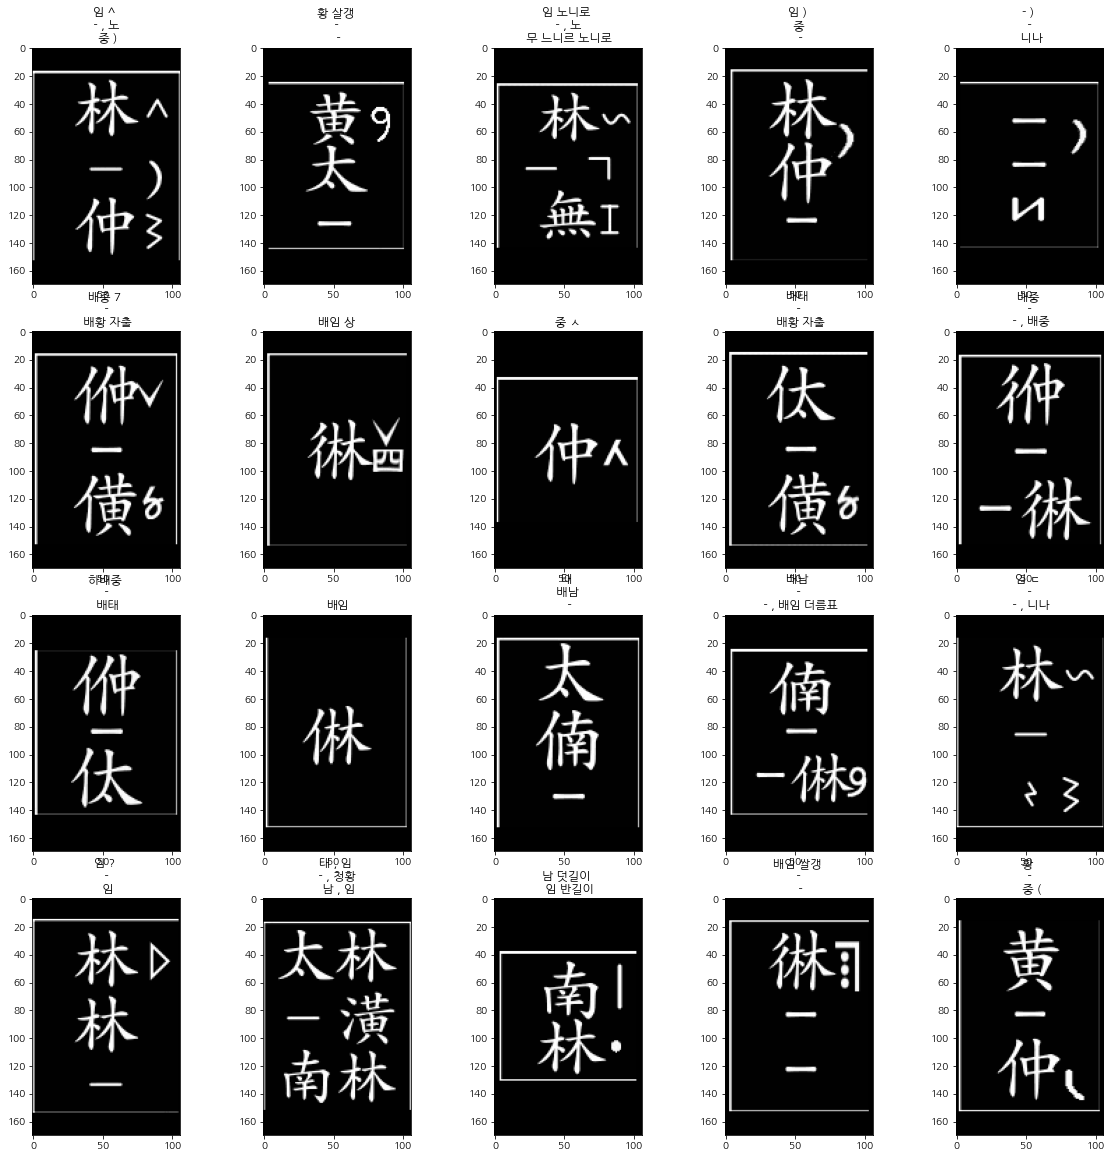

In [86]:
import koreanize_matplotlib

test_img, test_label, _ = next(iter(test_loader))


plt.figure(figsize=(20, 20))
for idx in range(20):
  plt.subplot(4, 5, idx+1)
  plt.imshow(test_img[idx].squeeze().cpu().numpy(), cmap='gray')
  output = tokenizer.decode(model.inference(test_img[idx:idx+1]))
  plt.title(output)
# test_img = test_img[idx:idx+1]
# plt.imshow(test_img.squeeze().cpu().numpy(), cmap='gray')
# tokenizer.decode(model.inference(test_img))

In [161]:
out[1].shape

torch.Size([32, 10, 15])

In [149]:
len(tokenizer.vocab)

114

In [61]:
beat_data = {
  "CONTI": 212169556,
  "Beat_0": 5583647,
  "Beat_24": 4881598,
  "Beat_48": 4622496,
  "Beat_36": 3906066,
  "Beat_12": 3556798,
  "Beat_72": 3451511,
  "Beat_60": 3304495,
  "Beat_84": 2610855,
  "Beat_18": 1628296,
  "Beat_42": 1505594,
  "Beat_30": 1316891,
  "Beat_6": 1257268,
  "Beat_66": 1256408,
  "Beat_54": 1173768,
  "Beat_90": 1060454,
  "Beat_78": 918478,
  "Beat_3": 407912,
  "Beat_32": 398408,
  "Beat_27": 377336,
  "Beat_80": 377333,
  "Beat_40": 375687,
  "Beat_16": 375410,
  "Beat_56": 367981,
  "Beat_64": 358478,
  "Beat_9": 344600,
  "Beat_21": 340496,
  "Beat_45": 339248,
  "Beat_39": 331842,
  "Beat_15": 331254,
  "Beat_33": 325980,
  "Beat_51": 322220,
  "Beat_88": 297531,
  "Beat_8": 279619,
  "Beat_63": 241304,
  "Beat_69": 240925,
  "Beat_68": 225544,
  "Beat_75": 224415,
  "Beat_62": 221215,
  "Beat_57": 221140,
  "0": 219895,
  "Beat_93": 210042,
  "Beat_96": 208814,
  "Beat_87": 205708,
  "Beat_81": 203494,
  "Beat_86": 193551,
  "Beat_92": 175828,
  "Beat_65": 160676,
  "Beat_38": 159217,
  "Beat_44": 155677,
  "Beat_108": 149121,
  "Beat_20": 143004,
  "Beat_4": 141009,
  "Beat_74": 135743,
  "Beat_120": 133632,
  "Beat_89": 133229,
  "Beat_2": 125770,
  "Beat_14": 125103,
  "Beat_77": 124371,
  "Beat_71": 122703,
  "Beat_50": 118322,
  "Beat_1": 117779,
  "Beat_83": 115479,
  "Beat_52": 115161,
  "Beat_132": 114791,
  "Beat_28": 107023,
  "Beat_26": 94203,
  "Beat_76": 93548,
  "Beat_49": 87607,
  "Beat_25": 83008,
  "Beat_37": 70893,
  "Beat_10": 68280,
  "Beat_13": 66471,
  "Beat_53": 66354,
  "Beat_58": 64695,
  "Beat_73": 63473,
  "Beat_46": 61832,
  "Beat_59": 60061,
  "Beat_43": 59487,
  "Beat_35": 59347,
  "Beat_19": 59118,
  "Beat_7": 58761,
  "Beat_22": 56667,
  "Beat_41": 56290,
  "Beat_34": 55510,
  "Beat_82": 55489,
  "Beat_55": 49424,
  "Beat_85": 46249,
  "Beat_91": 45130,
  "Beat_70": 45111,
  "Beat_94": 44892,
  "Beat_47": 44766,
  "Beat_61": 44227,
  "Beat_102": 41087,
  "Beat_79": 40652,
  "Beat_29": 40207,
  "Beat_31": 40170,
  "Beat_67": 40044,
  "Beat_5": 39332,
  "Beat_17": 37164,
  "Beat_114": 34961,
  "Beat_23": 28952,
  "Beat_126": 28790,
  "Beat_138": 28043,
  "Beat_11": 18731,
  "Beat_144": 18085,
  "Beat_104": 16959,
  "Beat_112": 15720,
  "Beat_95": 14708,
  "Beat_99": 14601,
  "Beat_105": 12004,
  "Beat_117": 11641,
  "Beat_135": 11309,
  "Beat_156": 11046,
  "Beat_111": 11038,
  "Beat_128": 11002,
  "Beat_136": 8900,
  "Beat_124": 8314,
  "Beat_100": 8289,
  "Beat_123": 8250,
  "Beat_141": 7827,
  "Beat_129": 7783,
  "Beat_168": 7609,
  "Beat_98": 7098,
  "Beat_118": 7013,
  "Beat_116": 6928,
  "Beat_140": 6761,
  "Beat_130": 6711,
  "Beat_115": 6186,
  "Beat_107": 6000,
  "Beat_101": 5860,
  "Beat_110": 5699,
  "Beat_109": 5360,
  "Beat_134": 5144,
  "Beat_106": 5073,
  "Beat_121": 4608,
  "Beat_127": 4449,
  "Beat_180": 4185,
  "Beat_137": 3752,
  "Beat_113": 3727,
  "Beat_122": 3659,
  "Beat_162": 3479,
  "Beat_150": 3442,
  "Beat_125": 3212,
  "Beat_131": 3070,
  "Beat_97": 2904,
  "Beat_103": 2895,
  "Beat_142": 2326,
  "Beat_119": 2249,
  "Beat_139": 1850,
  "Beat_133": 1694,
  "Beat_192": 1645,
  "Beat_174": 1311,
  "Beat_186": 1152,
  "Beat_160": 1022,
  "Beat_204": 1004,
  "Beat_152": 970,
  "Beat_143": 894,
  "Beat_147": 892,
  "Beat_158": 779,
  "Beat_176": 761,
  "Beat_159": 759,
  "Beat_153": 751,
  "Beat_165": 718,
  "Beat_240": 710,
  "Beat_164": 651,
  "Beat_216": 511,
  "Beat_198": 474,
  "Beat_161": 463,
  "Beat_148": 451,
  "Beat_154": 440,
  "Beat_146": 432,
  "Beat_171": 354,
  "Beat_184": 353,
  "Beat_264": 324,
  "Beat_252": 318,
  "Beat_182": 316,
  "Beat_177": 304,
  "Beat_166": 297,
  "Beat_210": 287,
  "Beat_228": 285,
  "Beat_149": 268,
  "Beat_183": 266,
  "Beat_157": 263,
  "Beat_189": 256,
  "Beat_155": 243,
  "Beat_151": 238,
  "Beat_179": 236,
  "Beat_167": 235,
  "Beat_173": 224,
  "Beat_185": 206,
  "Beat_170": 195,
  "Beat_145": 193,
  "Beat_246": 187,
  "Beat_188": 182,
  "Beat_163": 131,
  "Beat_195": 118,
  "Beat_213": 106,
  "Beat_181": 102,
  "Beat_222": 101,
  "Beat_207": 93,
  "Beat_201": 85,
  "Beat_276": 84,
  "Beat_172": 83,
  "Beat_208": 81,
  "Beat_178": 80,
  "Beat_209": 78,
  "Beat_200": 71,
  "Beat_212": 65,
  "Beat_206": 64,
  "Beat_197": 63,
  "Beat_243": 62,
  "Beat_191": 58,
  "Beat_234": 58,
  "Beat_203": 58,
  "Beat_194": 55,
  "Beat_175": 54,
  "Beat_258": 52,
  "Beat_169": 50,
  "Beat_288": 46,
  "Beat_270": 43,
  "Beat_312": 42,
  "Beat_214": 41,
  "Beat_219": 39,
  "Beat_190": 39,
  "Beat_187": 38,
  "Beat_231": 35,
  "Beat_255": 34,
  "Beat_336": 33,
  "Beat_237": 30,
  "Beat_249": 27,
  "Beat_324": 26,
  "Beat_260": 26,
  "Beat_267": 24,
  "Beat_257": 24,
  "Beat_318": 23,
  "Beat_196": 23,
  "Beat_225": 22,
  "Beat_202": 22,
  "Beat_215": 22,
  "Beat_248": 22,
  "Beat_254": 22,
  "Beat_272": 22,
  "Beat_282": 21,
  "Beat_263": 21,
  "Beat_261": 19,
  "Beat_348": 18,
  "Beat_226": 17,
  "Beat_242": 17,
  "Beat_266": 17,
  "Beat_199": 16,
  "Beat_233": 16,
  "Beat_236": 16,
  "Beat_193": 16,
  "Beat_217": 16,
  "Beat_211": 16,
  "Beat_205": 15,
  "Beat_223": 15,
  "Beat_269": 15,
  "Beat_275": 15,
  "Beat_277": 15,
  "Beat_224": 15,
  "Beat_220": 14,
  "Beat_230": 14,
  "Beat_256": 12,
  "Beat_273": 11,
  "Beat_239": 11,
  "Beat_245": 11,
  "Beat_279": 10,
  "Beat_285": 10,
  "Beat_238": 9,
  "Beat_244": 9,
  "Beat_251": 9,
  "Beat_268": 9,
  "Beat_259": 9,
  "Beat_342": 8,
  "Beat_227": 8,
  "Beat_247": 8,
  "Beat_253": 8,
  "Beat_271": 8,
  "Beat_250": 7,
  "Beat_281": 7,
  "Beat_284": 7,
  "Beat_323": 7,
  "Beat_332": 7,
  "Beat_232": 7,
  "Beat_265": 7,
  "Beat_291": 6,
  "Beat_294": 6,
  "Beat_297": 6,
  "Beat_300": 6,
  "Beat_303": 6,
  "Beat_306": 6,
  "Beat_309": 6,
  "Beat_315": 6,
  "Beat_262": 6,
  "Beat_274": 6,
  "Beat_298": 6,
  "Beat_328": 6,
  "Beat_278": 6,
  "Beat_293": 5,
  "Beat_337": 5,
  "Beat_307": 5,
  "Beat_321": 4,
  "Beat_327": 4,
  "Beat_330": 4,
  "Beat_333": 4,
  "Beat_339": 4,
  "Beat_345": 4,
  "Beat_351": 4,
  "Beat_354": 4,
  "Beat_357": 4,
  "Beat_229": 4,
  "Beat_280": 4,
  "Beat_241": 4,
  "Beat_235": 4,
  "Beat_302": 4,
  "Beat_286": 3,
  "Beat_329": 3,
  "Beat_338": 3,
  "Beat_350": 3,
  "Beat_326": 3,
  "Beat_218": 2,
  "Beat_283": 2,
  "Beat_320": 2,
  "Beat_335": 2,
  "Beat_341": 2,
  "Beat_344": 2,
  "Beat_347": 2,
  "Beat_353": 2,
  "Beat_356": 2,
  "Beat_290": 1,
  "Beat_292": 1,
  "Beat_295": 1,
  "Beat_296": 1,
  "Beat_299": 1,
  "Beat_301": 1,
  "Beat_305": 1,
  "Beat_308": 1,
  "Beat_310": 1,
  "Beat_314": 1,
  "Beat_316": 1,
  "Beat_319": 1,
  "Beat_325": 1,
  "Beat_334": 1,
  "Beat_349": 1,
  "Beat_221": 1,
  "Beat_317": 1
}


In [63]:
from math import log2

beat_data_int = {int(k.replace('Beat_', '')):v for k, v in beat_data.items() if 'Beat' in k}
max_beat = max(beat_data_int.keys())
beat_data = [log2(beat_data_int.get(i, 0)+1) for i in range(max_beat+1)]


Text(0, 0.5, 'frequency')

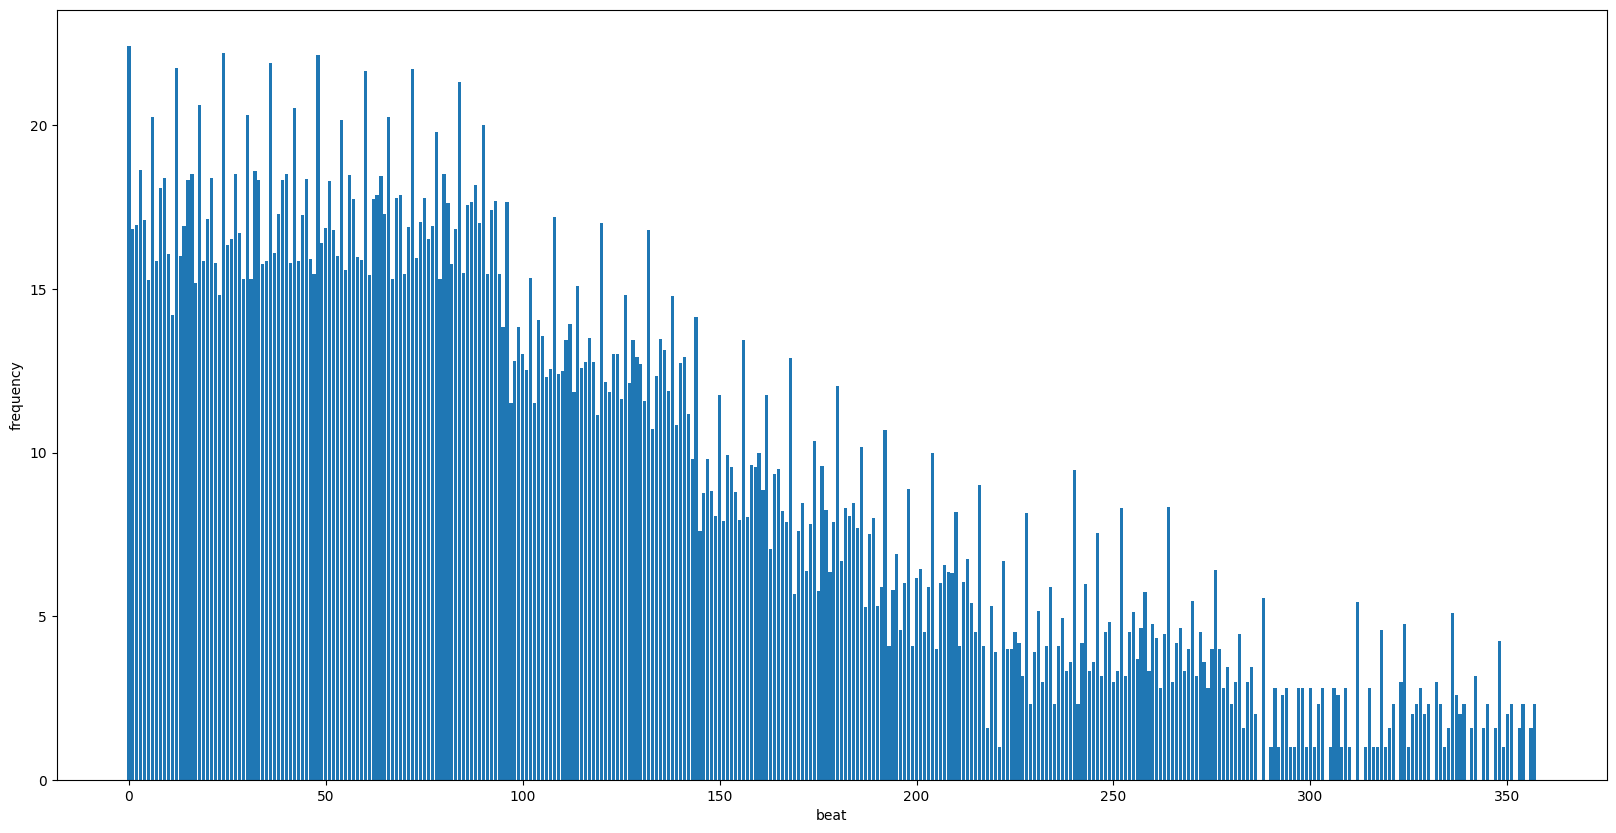

In [64]:
# draw histogram

plt.figure(figsize=(20, 10))
plt.bar(range(len(beat_data)), beat_data)
plt.xlabel('beat')
plt.ylabel('frequency')